In [1]:
import numpy as np
import pandas as pd
import gget
import glob
import networkx as nx
import os
import seaborn as sns
import gget
from textwrap import fill
import scanpy as sc
import anndata as an
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
from scipy.stats import zscore
import scipy
from scipy.sparse import csr_matrix 

# locals
import utils as ut
import plotting as plt2

sc.settings.verbosity = 3  

# Load iHSC

In [2]:
fpath = "/scratch/indikar_root/indikar1/cstansbu/HSC/scanpy/analysis.anndata.h5ad"

adata = sc.read_h5ad(fpath)
adata.X = adata.layers['raw_counts'].copy()
adata.obs['UMAP 1'] = adata.obsm['X_umap'][:, 0]
adata.obs['UMAP 2'] = adata.obsm['X_umap'][:, 1]
adata.obs['cell_type'] = adata.obs['cluster_str']
adata.obs['dataset'] = 'iHSC'

sc.pp.normalize_total(
        adata, 
        target_sum=1e6,
        key_added='norm_factor',
)

adata.layers["cpm"] = adata.X.copy()

sc.pp.log1p(adata)

adata

normalizing counts per cell
    finished (0:00:00)


AnnData object with n_obs × n_vars = 8563 × 15065
    obs: 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'EC_score', 'EB_score', 'FB_score', 'HSC_score', 'MK_score', 'new_cluster', 'cluster_str', 'UMAP 1', 'UMAP 2', 'cell_type', 'dataset', 'norm_factor'
    var: 'gene_name', 'Chromosome', 'Start', 'End', 'Strand', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'ensembl_id', 'tf', 'bj', 'hsc', 'EC', 'EB', 'FB', 'HSC', 'MK', 'cluster_genes'
    uns: 'HSC_vs_FB', 'HSC_vs_FB_pure', 'clusters', 'deg', 'fb_vs_hsc_up', 'go_annotations', 'hsc_v_fib_up', 'hvg', 'log1p', 'neighbors', 'new_cluster', 'new_cluster_colors', 'panglaodb', 'pca', 'scenic_transcription_factors', 'scrublet', 'tabula_sapiens_deg', 'umap', 'v5_tags'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'filtered_counts', 'raw_counts', 'cp

# Load gomes

In [3]:
fpath = "/nfs/turbo/umms-indikar/shared/projects/HSC/data/gomes_2018/gomes.h5ad"

bdata = sc.read_h5ad(fpath)
bdata.var_names_make_unique()

sc.pp.filter_genes(bdata, min_cells=3)

overlapping_genes = [x for x in bdata.var_names if x in adata.var_names]
bdata = bdata[:, overlapping_genes]
bdata.obs['dataset'] = 'gomes'
bdata.X = bdata.layers['raw_counts'].copy()

sc.pp.normalize_total(
        bdata, 
        target_sum=1e6,
        key_added='norm_factor',
)

bdata.layers["cpm"] = bdata.X.copy()

sc.pp.log1p(bdata)

bdata

filtered out 28021 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)


AnnData object with n_obs × n_vars = 286 × 11524
    obs: 'cell_type', 'cell_num', 'dataset', 'norm_factor'
    var: 'n_cells'
    uns: 'log1p'
    layers: 'raw_counts', 'cpm'

# combine

In [4]:
pdf = an.concat([adata, bdata], join='outer')
sc.pp.filter_genes(pdf, min_cells=3)
pdf

filtered out 1 genes that are detected in less than 3 cells


AnnData object with n_obs × n_vars = 8849 × 15064
    obs: 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'EC_score', 'EB_score', 'FB_score', 'HSC_score', 'MK_score', 'new_cluster', 'cluster_str', 'UMAP 1', 'UMAP 2', 'cell_type', 'dataset', 'norm_factor', 'cell_num'
    var: 'n_cells'
    obsm: 'X_pca', 'X_umap'
    layers: 'filtered_counts', 'raw_counts', 'cpm'

Text(0.5, 1373.7171717171716, '')

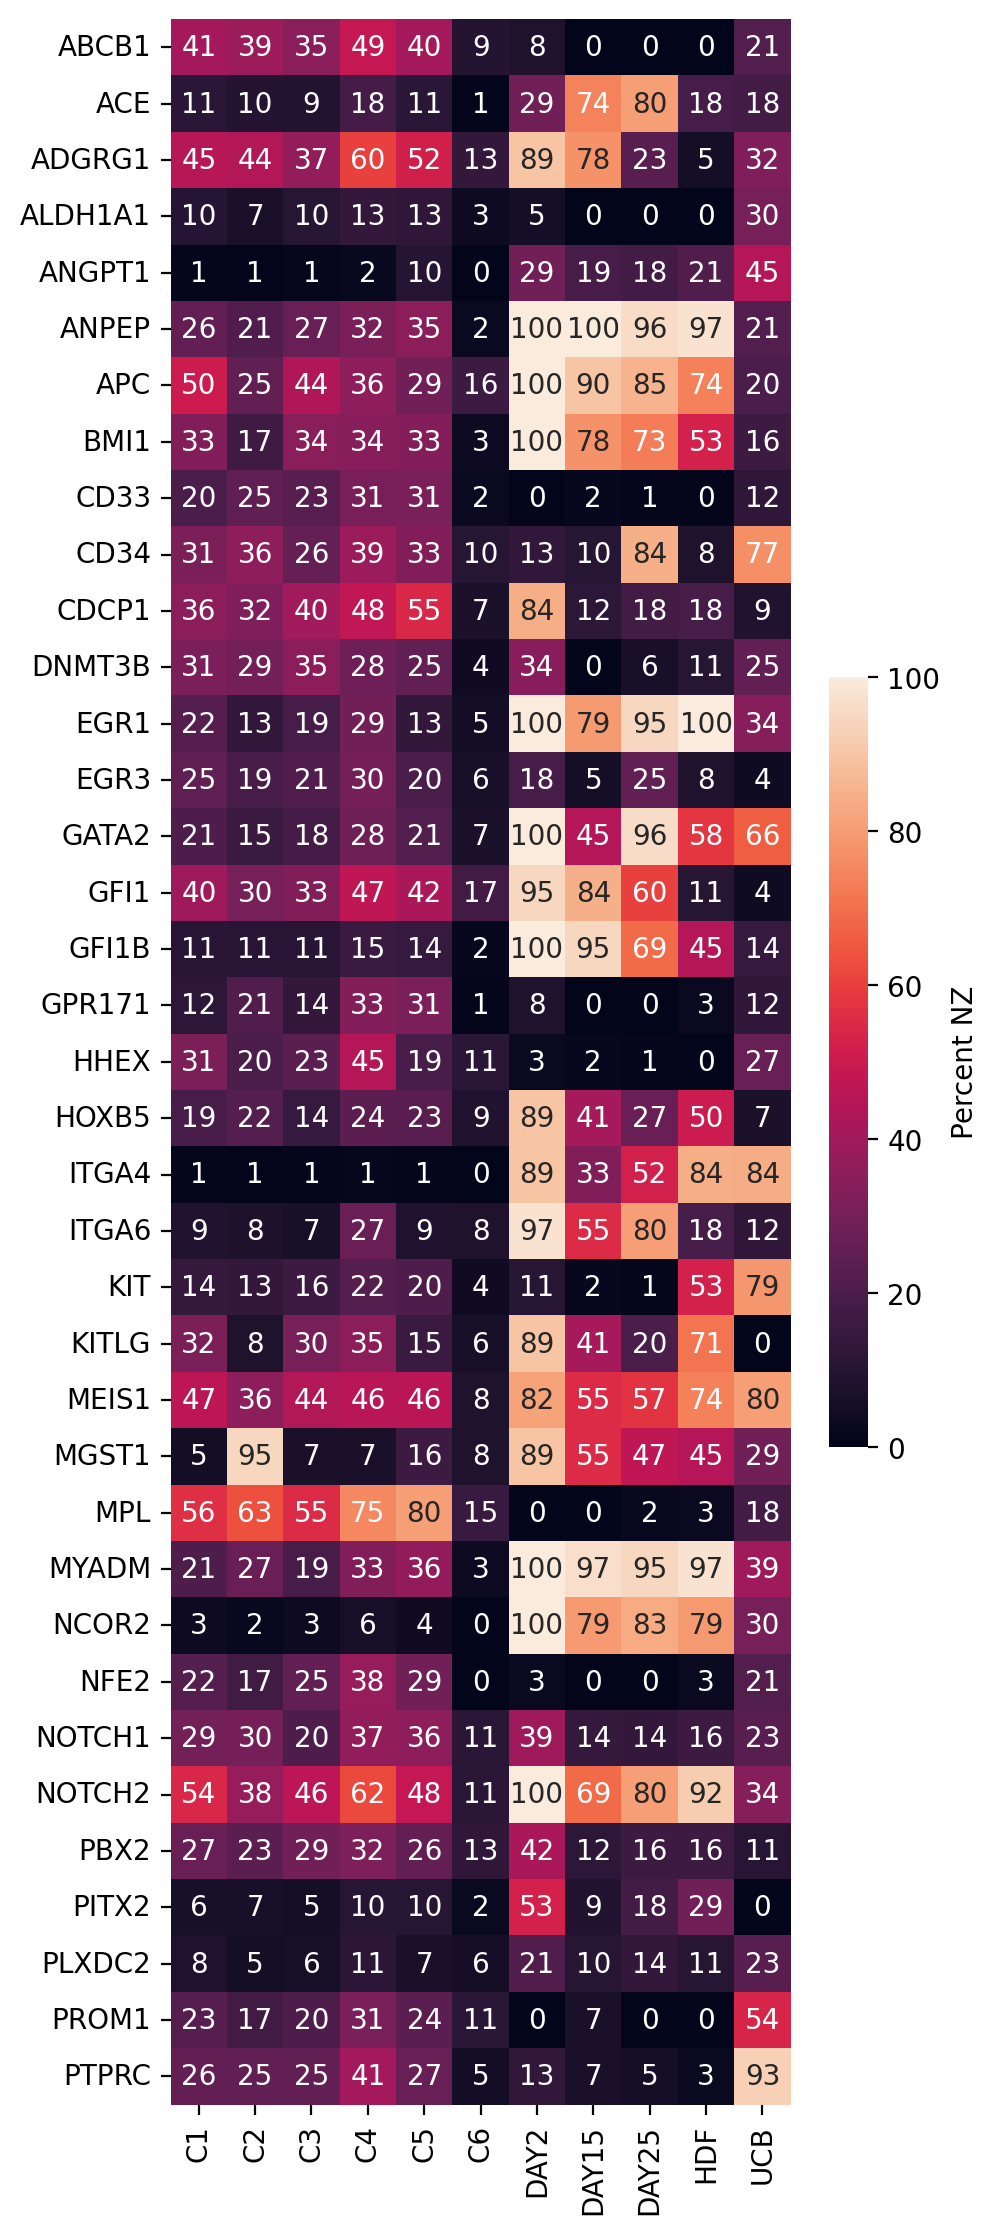

In [66]:
def get_matrix(gene_list, adata=pdf):
    
    X = []
    adata = adata[:, gene_list]
    
    for cell_type, group in adata.obs.groupby('cell_type', observed=True):
        group_idx = group.index
        
        Xrow = adata[group_idx, :].to_df()
        Xrow = (Xrow != 0).mean(axis=0) * 100
        Xrow = Xrow.to_dict()
        Xrow['cell_type'] = cell_type
        
        X.append(Xrow)
        
    X = pd.DataFrame(X)
    X = X.set_index('cell_type')
    return X
    
    
gene_list = [
'ABCB1',
 'ACE',
 'ADGRG1',
 'ALDH1A1',
 'ANGPT1',
 'ANPEP',
 'APC',
 'BMI1',
 'CD33',
 'CD34',
 'CDCP1',
 'DNMT3B',
 'EGR1',
 'EGR3',
 'GATA2',
 'GFI1',
 'GFI1B',
 'GPR171',
 'HHEX',
 'HOXB5',
 'ITGA4',
 'ITGA6',
 'KIT',
 'KITLG',
 'MEIS1',
 'MGST1',
 'MPL',
 'MYADM',
 'NCOR2',
 'NFE2',
 'NOTCH1',
 'NOTCH2',
 'PBX2',
 'PITX2',
 'PLXDC2',
 'PROM1',
 'PTPRC',
]

X = get_matrix(gene_list)


plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 25

sns.heatmap(
    X.T,
    square=True,
    # lw=1,
    annot=True,
    fmt="0.0f",
    cbar_kws={'shrink' : 0.2, 'label' : 'Percent NZ'}
)

plt.ylabel("")
plt.xlabel("")

In [29]:
pang = adata.uns['panglaodb']
hsc_genes = list(pang[pang['cell_type'] == 'Hematopoietic stem cells']['gene_name'].unique())
hsc_genes[:10]

['THY1',
 'MPL',
 'KIT',
 'PROM1',
 'FLT3',
 'SLAMF1',
 'CXCR4',
 'TEK',
 'ABCB1',
 'ABCG2']

In [70]:
X = pdf[pdf.obs['dataset'] == 'iHSC', :].to_df()
Y = pdf[pdf.obs['dataset'] == 'gomes', :].to_df()

mean_exp = pd.concat([X.mean(axis=0), Y.mean(axis=0)], axis=1)
mean_exp.columns = ['iHSC', 'Gomes']
mean_exp['diff'] = mean_exp['iHSC'] -  mean_exp['Gomes']
mean_exp['diff_abs'] = mean_exp['diff'].abs()

mean_exp = mean_exp.loc[hsc_genes]
mean_exp = mean_exp.sort_values(by='diff_abs')

,iHSC,Gomes,diff,diff_abs
GFI1B,0.541948,3.220555,-2.678607,2.678607
MYADM,1.156267,3.839730,-2.683463,2.683463
ITGA4,0.042422,2.777843,-2.735421,2.735421
RUNX1,0.001650,3.072712,-3.071061,3.071061
MPL,3.271726,0.121514,3.150212,3.150212
ANPEP,1.273503,4.476956,-3.203453,3.203453
THY1,1.474481,4.702244,-3.227763,3.227763
GNL3,0.262834,3.936140,-3.673306,3.673306
TXNIP,0.139675,4.195988,-4.056313,4.056313
EGR1,0.976675,5.133733,-4.157058,4.157058


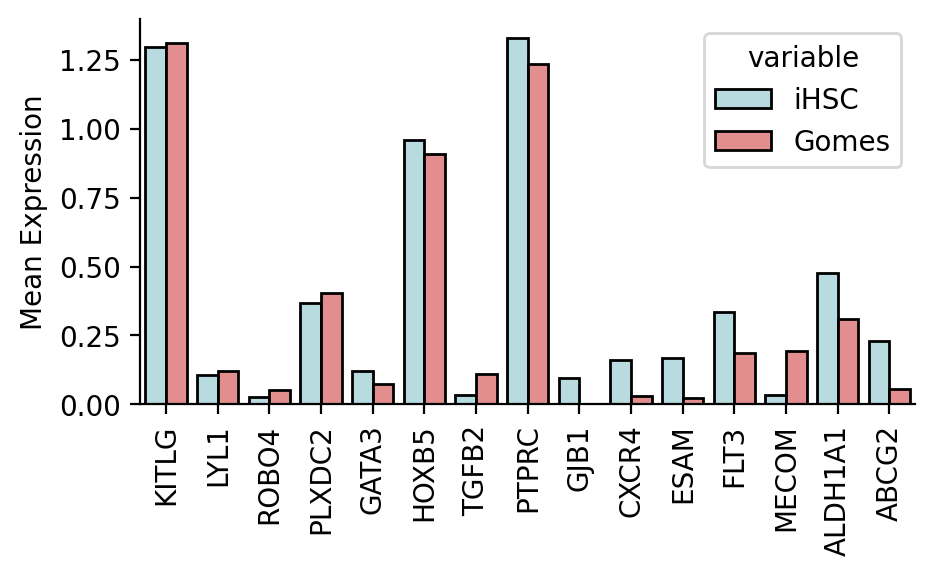

In [87]:
n_genes = 15

plot = mean_exp.head(n_genes).reset_index(names='gene_name')
plot = pd.melt(plot, id_vars='gene_name', value_vars=['iHSC', 'Gomes'])

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 2.5

sns.barplot(
    plot,
    x='gene_name',
    y='value',
    hue='variable',
    ec='k',
    palette=['#B0E0E6', '#F08080'],
)

sns.despine()
plt.ylabel("Mean Expression")
plt.xlabel("")

plt.gca().tick_params(axis='x', rotation=90)

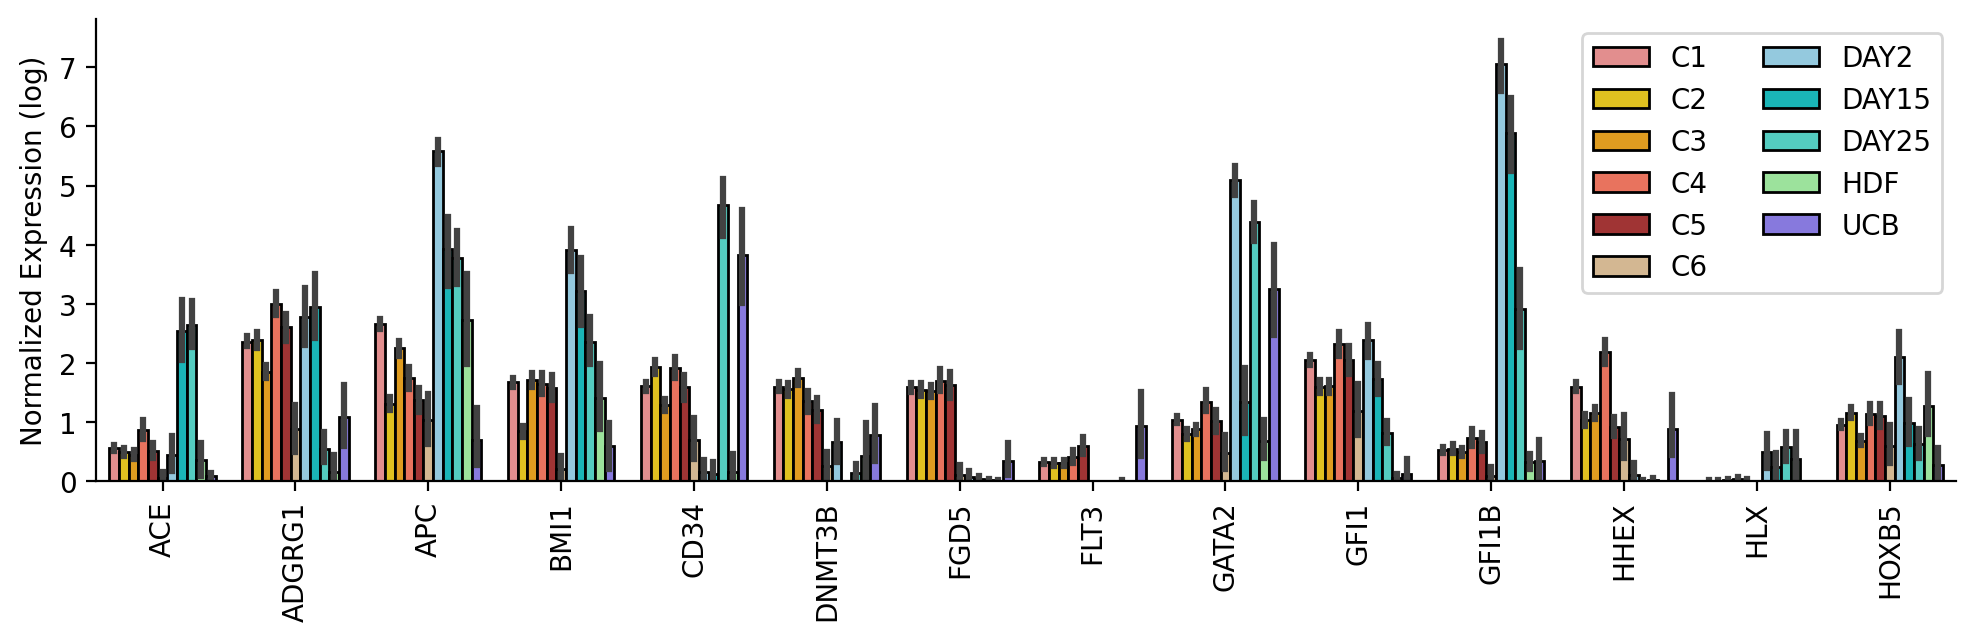

In [128]:
def get_matrix_mean_expression(gene_list, adata=pdf):
    
    X = []
    adata = adata[:, gene_list]
    
    for cell_type, group in adata.obs.groupby('cell_type', observed=True):
        group_idx = group.index
        
        Xrow = adata[group_idx, :].to_df()
        Xrow = Xrow.reset_index(names='cell_id')
        Xrow = pd.melt(Xrow, id_vars='cell_id')
        Xrow['cell_type'] = cell_type
        X.append(Xrow)

    X = pd.concat(X)
    return X


gene_list = [
    'ACE', 'ADGRG1', 'APC', 'BMI1', 'CD34', 'DNMT3B','FGD5', 
    'FLT3', 'GATA2', 'GFI1', 'GFI1B', 'HHEX', 'HLX', 'HOXB5',
    # 'ITGA4', 'ITGA6', 'KIT', 'KITLG', 'LYL1', 'MAFF',
#     'MECOM', 'MEIS1', 'MGST1', 'MPL', 'MYADM', 'MYCT1',
#     'NCOR2', 'NEO1', 'NFE2', 'NKX2-3', 'NKX3-1', 'NOTCH1',
#     'NOTCH2', 'PBX2', 'PITX2', 'PLXDC2', 'PRNP', 'PROM1', 
#     'PTPRC', 'RGS18', 'ROBO4', 'RUNX1', 'SLAMF1', 'SPN', 
#     'TAF7', 'TAL1', 'TEK', 'TET2', 'TGFB2', 'THY1', 'TLR2',
#     'TXNIP',
]

colors = [
    # Warm colors (6)
    "#F08080",  # Light Coral
    "#FFD700",  # Gold
    "#FFA500",  # Orange
    "#FF6347",  # Tomato
    "#B22222",  # Firebrick
    "#DEB887",  # Burlywood

    # Cool colors (5)
    "#87CEEB",  # Sky Blue
    "#00CED1",  # Dark Turquoise
    "#40E0D0",  # Turquoise
    "#90EE90",  # Light Green
    "#7B68EE",  # Medium Slate Blue
]


plot = get_matrix_mean_expression(gene_list)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 12, 3

sns.barplot(
    data=plot,
    x='variable',
    y='value',
    hue='cell_type',
    ec='k',
    palette=colors,
)

plt.gca().tick_params(axis='x', rotation=90)
plt.ylabel('Normalized Expression (log)')
plt.xlabel('')
sns.despine()

sns.move_legend(
    plt.gca(),
    title="",
    ncol=2,
    loc='upper right',
    # bbox_to_anchor=(1.3, 1)
)


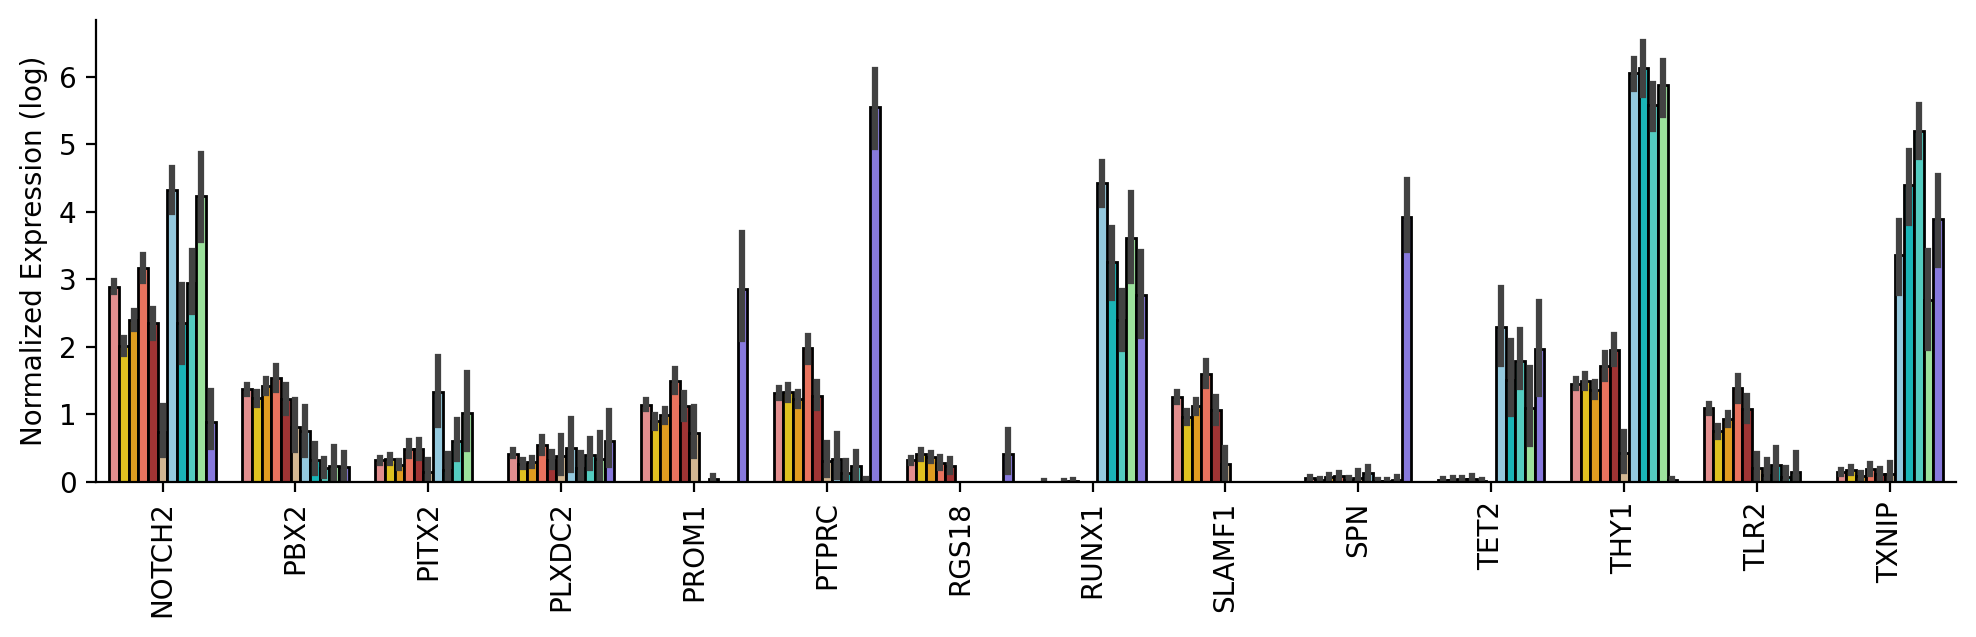

In [136]:
def get_matrix_mean_expression(gene_list, adata=pdf):
    
    X = []
    adata = adata[:, gene_list]
    
    for cell_type, group in adata.obs.groupby('cell_type', observed=True):
        group_idx = group.index
        
        Xrow = adata[group_idx, :].to_df()
        Xrow = Xrow.reset_index(names='cell_id')
        Xrow = pd.melt(Xrow, id_vars='cell_id')
        Xrow['cell_type'] = cell_type
        X.append(Xrow)

    X = pd.concat(X)
    return X


gene_list = [
    # 'ITGA4', 'ITGA6', 'KIT', 'KITLG', 'MAFF',
    # 'MECOM', 'MEIS1', 'MGST1', 'MPL', 'MYADM', 'MYCT1',
    # 'NCOR2', 'NFE2','NOTCH1',
    'NOTCH2', 'PBX2', 'PITX2', 'PLXDC2', 'PROM1', 
    'PTPRC', 'RGS18', 'RUNX1', 'SLAMF1', 'SPN', 'TET2', 'THY1', 'TLR2',
    'TXNIP',
]

colors = [
    # Warm colors (6)
    "#F08080",  # Light Coral
    "#FFD700",  # Gold
    "#FFA500",  # Orange
    "#FF6347",  # Tomato
    "#B22222",  # Firebrick
    "#DEB887",  # Burlywood

    # Cool colors (5)
    "#87CEEB",  # Sky Blue
    "#00CED1",  # Dark Turquoise
    "#40E0D0",  # Turquoise
    "#90EE90",  # Light Green
    "#7B68EE",  # Medium Slate Blue
]


plot = get_matrix_mean_expression(gene_list)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 12, 3

sns.barplot(
    data=plot,
    x='variable',
    y='value',
    hue='cell_type',
    ec='k',
    palette=colors,
    legend=False,
)

plt.gca().tick_params(axis='x', rotation=90)
plt.ylabel('Normalized Expression (log)')
plt.xlabel('')
sns.despine()

# sns.move_legend(
#     plt.gca(),
#     title="",
#     ncol=2,
#     loc='upper right',
#     # bbox_to_anchor=(1.3, 1)
# )


In [ ]:
break

In [ ]:
def get_matrix(gene_list, adata=adata, bdata=bdata):

In [ ]:
break

In [ ]:
def percent_nz(gene_list, adata=adata, bdata=bdata):
    
    X = adata[:, gene_list].to_df()
    Y = bdata[:, gene_list].to_df()
    
    # nonzero percentage computation
    X = (X != 0).mean(axis=0) * 100
    Y = (Y != 0).mean(axis=0) * 100
    
    plot = pd.concat([X, Y], axis=1)
    plot.columns = ['iHSC', 'Gomes']
    return plot
    
    
    
gene_list = [
    'CD34',
    'ITGA2',
    'CD164',
    'GATA2',
    'ACE',
    'FLT1',
    'GFI1B',
]

percent_nz(gene_list)

# some comparisons

            cell_id  data cell_type gene_name     value
0  AAACCCAAGGTTACCT  iHSC        C1      CD34  5.723490
1  AAACCCAAGTTGAAGT  iHSC        C1      CD34  0.000000
2  AAACCCAAGTTGTCGT  iHSC        C4      CD34  0.000000
3  AAACCCACAGAAGCGT  iHSC        C2      CD34  5.675138
4  AAACCCACAGGAGGTT  iHSC        C1      CD34  4.252978


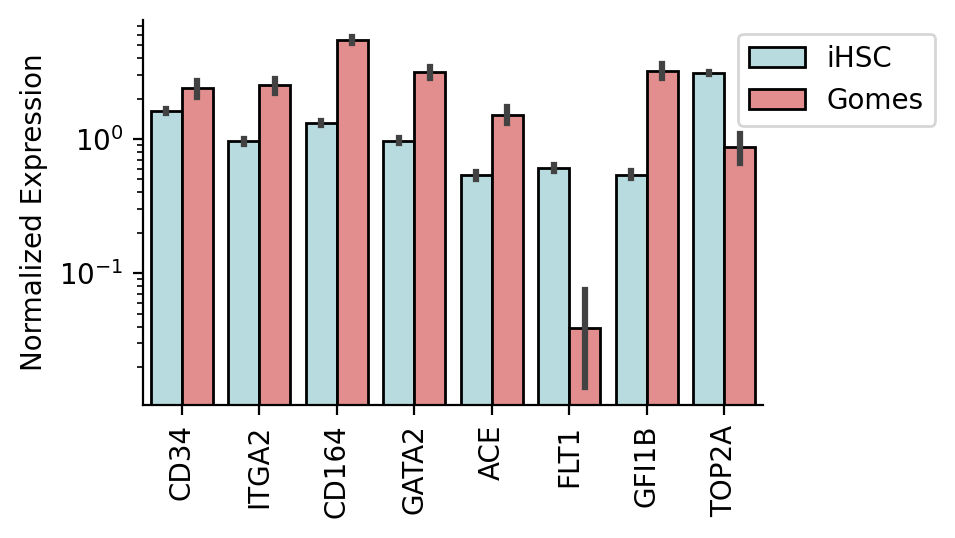

In [88]:
def plot_distributions(gene_list, adata=adata, bdata=bdata):
    
    X = adata[:, gene_list].to_df().reset_index(names='cell_id')
    Y = bdata[:, gene_list].to_df().reset_index(names='cell_id')
    
    X['data'] = 'iHSC'
    Y['data'] = 'Gomes'
    
    X['cell_type'] = adata.obs['cluster_str'].values
    Y['cell_type'] = bdata.obs['cell_type'].values
    
    
    X = pd.melt(X, id_vars=['cell_id', 'data', 'cell_type'], var_name='gene_name')
    Y = pd.melt(Y, id_vars=['cell_id', 'data', 'cell_type'], var_name='gene_name')
    
    plot = pd.concat([X, Y])
    # plot = plot[plot['value'] > 0]
    
    print(plot.head())
    
    sns.barplot(
        data=plot,
        x='gene_name',
        y='value',
        hue='data',
        ec='k',
        palette=['#B0E0E6', '#F08080'],
    )
    
    plt.yscale('log')
    plt.xlabel("")
    plt.ylabel("Normalized Expression")
    sns.despine()
    
    sns.move_legend(
        plt.gca(),
        title="",
        loc='upper right',
        bbox_to_anchor=(1.3, 1),
    )
    
    plt.gca().tick_params(axis='x', rotation=90)
    
    
        

gene_list = [
    'CD34',
    'ITGA2',
    'CD164',
    'GATA2',
    'ACE',
    'FLT1',
    'GFI1B',
    'TOP2A'
]

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 2.5
plot_distributions(
    gene_list, 
    adata=adata,
    bdata=bdata,
)


In [ ]:
bdata[bdata.obs['cell_type'].isin(['DAY25', 'DAY15'])]

In [ ]:
bdata.obs['cell_type'].value_counts()